![](https://miro.medium.com/max/700/1*HgXA9v1EsqlrRDaC_iORhQ.png)

## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import transformers #huggingface transformers library

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Configuration for TPUs

The given news classifier is trained on using BERT model. Since, BERT is a very large model, it requires gpu's and tpu's to train quickly. Here, I have used TPU's provided by Kaggle to train this model.

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Preprocessing

In [3]:
df = pd.read_json('/kaggle/input/news-category-dataset/News_Category_Dataset_v2.json', lines = True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
# WORLDPOST and THE WORLDPOST were given as two separate categories in the dataset. Here I change the category THE WORLDPOST to WORLDPOST 
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [5]:
print(f"The dataset contains { df.category.nunique() } unique categories")

The dataset contains 40 unique categories


In [6]:
#label encoding the categories. After this each category would be mapped to an integer.
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['category'])

In [7]:
#since I am using bert-large-uncased as the model, I am converting each of the news headlines and descriptions into lower case.
df['headline'] = df['headline'].apply(lambda headline: str(headline).lower())
df['short_description'] = df['short_description'].apply(lambda descr: str(descr).lower())

In [8]:
#calculating the length of headlines and descriptions
df['descr_len'] = df['short_description'].apply(lambda x: len(str(x).split()))
df['headline_len'] = df['headline'].apply(lambda x: len(str(x).split()))

In [9]:
df.describe()

,categoryEncoded,descr_len,headline_len
count,200853.000000,200853.000000,200853.000000
mean,22.024366,19.728289,9.538563
std,10.753991,14.409189,3.089320
min,0.000000,0.000000,0.000000
25%,13.000000,10.000000,7.000000
50%,24.000000,19.000000,10.000000
75%,30.000000,24.000000,12.000000
max,39.000000,243.000000,44.000000


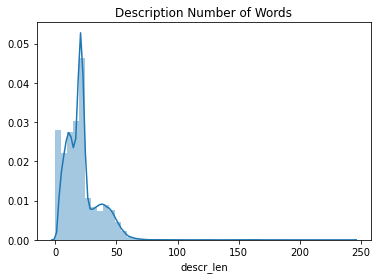

In [10]:
sns.distplot(df['descr_len'])
plt.title('Description Number of Words')
plt.show()

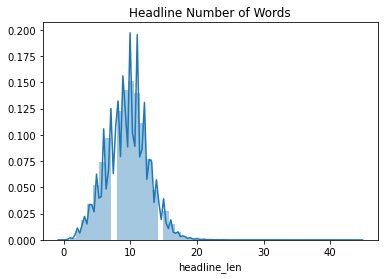

In [11]:
sns.distplot(df['headline_len'])
plt.title('Headline Number of Words')
plt.show()

As we can see, that there are a lot of samples that have a description length of 0, however almost all articles have a headline. Going with the intuition that the headline is often more descriptive of the category of the news, as well as to provide more text data to the model, I add news headlines to the short description and modify the description of the news samples.

In [12]:
df['short_description'] = df['headline'] + df['short_description']

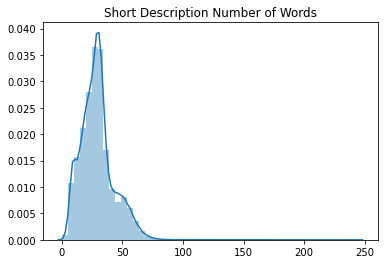

In [13]:
sns.distplot(df['headline_len'] + df['descr_len'])
plt.title('Short Description Number of Words')
plt.show()

## Tokenizing

* I use the HuggingFace tokenizer for bert to tokenize the given news descriptions. After splitting up the dataset into train and test, we encode both the training data and the testing data. 
* One more thing to notice is that we truncate the last part of the sentence when encoding it, thus adding the headlines to the front of the description means that our model will always have the headline of the news sample.

In [14]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [15]:
#bert large uncased pretrained tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

In [16]:
X_train,X_test ,y_train,y_test = train_test_split(df['short_description'], df['categoryEncoded'], random_state = 2020, test_size = 0.3)

In [17]:
#tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen=80)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=40,dtype = 'int32')
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen=80)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=40,dtype = 'int32')

## Building the model

In [18]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 40 neurons as the number of unique categories is 40. 
    out = tf.keras.layers.Dense(40, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(lr=3e-5), loss=loss, metrics=['accuracy'])
    return model

In [19]:
#building the model on tpu
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len=80)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 80)]              0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 80, 1024), (None, 335141888 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 40)                41000     
Total params: 335,182,888
Trainable params: 335,182,888
Non-trainable params: 0
_________________________________________________________________


## Training

In [20]:
#creating the training and testing dataset.
BATCH_SIZE = 32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [21]:
#training for 10 epochs
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=10
)

Epoch 1/10
549/549 [==============================] - 183s 333ms/step - loss: 1.3580 - accuracy: 0.6216
Epoch 2/10
549/549 [==============================] - 183s 333ms/step - loss: 0.9333 - accuracy: 0.7186
Epoch 3/10
549/549 [==============================] - 183s 333ms/step - loss: 0.7353 - accuracy: 0.7724
Epoch 4/10
549/549 [==============================] - 183s 333ms/step - loss: 0.5707 - accuracy: 0.8191
Epoch 5/10
549/549 [==============================] - 182s 332ms/step - loss: 0.4123 - accuracy: 0.8666
Epoch 6/10
549/549 [==============================] - 183s 333ms/step - loss: 0.2850 - accuracy: 0.9061
Epoch 7/10
549/549 [==============================] - 183s 333ms/step - loss: 0.1912 - accuracy: 0.9364
Epoch 8/10
549/549 [==============================] - 183s 332ms/step - loss: 0.1332 - accuracy: 0.9548
Epoch 9/10
549/549 [==============================] - 183s 333ms/step - loss: 0.1025 - accuracy: 0.9656
Epoch 10/10
549/549 [==============================] - 183s 333m

## Evaluation

In [22]:
#making predictions
preds = model.predict(test_dataset,verbose = 1)
#converting the one hot vector output to a linear numpy array.
pred_classes = np.argmax(preds, axis = 1)

236/236 [==============================] - 43s 183ms/step


In [23]:
#extracting the classes from the label encoder
encoded_classes = encoder.classes_
#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in pred_classes]
true_category = [encoded_classes[x] for x in y_test]

In [24]:
result_df = pd.DataFrame({'description':X_test,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

,description,true_category,predicted_category
75589,"huffpost rise morning newsbrief, november 4wel...",POLITICS,POLITICS
21665,donald trump's lawyer claims president was nev...,POLITICS,POLITICS
51481,the feminist comic series for fans of 'strange...,ARTS & CULTURE,ARTS & CULTURE
20578,obamacare repeal moves ahead with key senate v...,POLITICS,POLITICS
58445,mount holyoke commencement speaker thanks acti...,COLLEGE,BLACK VOICES


In [25]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.7045273499734467


In [26]:
result_df.to_csv('testPredictions.csv', index = False)

## Confusion Matrix

In [27]:
result_df[result_df['true_category']!=result_df['predicted_category']]

,description,true_category,predicted_category
58445,mount holyoke commencement speaker thanks acti...,COLLEGE,BLACK VOICES
25864,manchester blood banks receive 'overwhelming' ...,WORLDPOST,WORLD NEWS
112055,standing tall for native american dayan unprec...,MEDIA,POLITICS
191946,something very cool happened to my friendsmoth...,PARENTING,WOMEN
136803,it is never too late to have a happy adulthood...,WELLNESS,PARENTING
...,...,...,...
2844,there's one letter in the alphabet that almost...,SCIENCE,COMEDY
119546,hundreds of toddlers said to be taken into cus...,LATINO VOICES,POLITICS
9725,traveling ethiopia taught me to appreciate its...,BLACK VOICES,TRAVEL
57660,spoof gum commercial chews away at islamophobi...,RELIGION,COMEDY


In [28]:
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

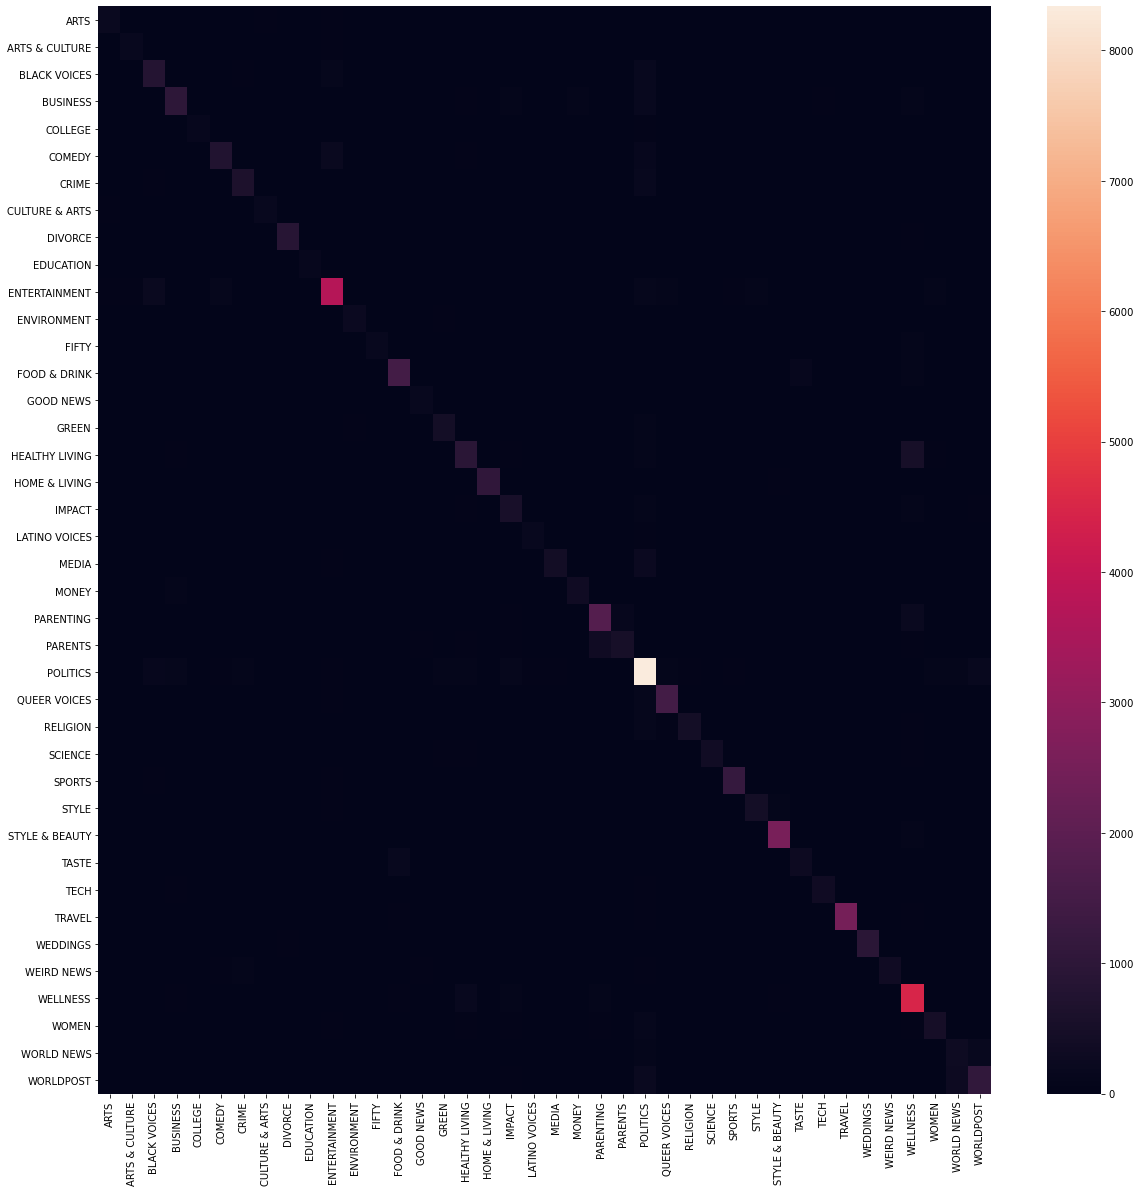

In [29]:
df_cm = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(df_cm)